In [1]:
def sd(array):
    import numpy as np
    array=np.array(array)
    result=np.std(array)
    return result

def dnorm(x,mean=0,sd =1,log=False):
    from scipy.stats import norm
    if log==False:
        result=norm.pdf(x,loc=mean,scale=sd)
    elif log==True:
        result=norm.logpdf(x,loc=mean,scale=sd)
    return result

def dexp(x,loc=0,scale=1,log=False):
    from scipy.stats import expon
    if log==False:
        result = expon.pdf(x,loc=loc,scale=scale)
    elif log==True:
        result = expon.logpdf(x,loc=loc,scale=scale)
    return result

In [2]:
import numpy as np
import pandas as pd

data = pd.read_csv("WaffleDivorce.csv",sep=';')

data_A = (data.MedianAgeMarriage - np.mean(data.MedianAgeMarriage) ) / np.std(data.MedianAgeMarriage)
data_D = (data.Divorce - data.Divorce.mean() ) / data.Divorce.std()
data_M = (data.Marriage - data.Marriage.mean() ) / data.Marriage.std()

In [3]:
sd(data.MedianAgeMarriage)

1.231131187160816

In [4]:
sd(data.Divorce)

1.8025138002245642

In [5]:
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

with pm.Model() as m5_1:
    a = pm.Normal("a", 0.0, 0.2)
    bA = pm.Normal("bA", 0.0, 0.5)
    mu = a + bA * data_A
    sigma = pm.Exponential("sigma", 1.0)
    obs = pm.Normal("Divorce", mu=mu, sigma=sigma, observed=data_D)
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=10)

Text(0.5, 1.0, 'm5.1')

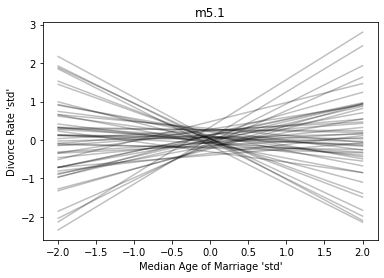

In [6]:
_, ax = plt.subplots()

x = np.linspace(-2, 2, 100)

for a, b in zip(prior_checks["a"], prior_checks["bA"]):
    y = a + b * x
    ax.plot(x, y, c="k", alpha=0.25)

ax.set_xlabel("Median Age of Marriage 'std'")
ax.set_ylabel("Divorce Rate 'std'")
ax.set_title("m5.1")

In [7]:
with pm.Model() as m5_2:
    a = pm.Normal("a", 0.0, 0.2)
    bM = pm.Normal("bM", 0.0, 0.5)
    mu = a + bM * data_M
    sigma = pm.Exponential("sigma", 1.0)
    obs = pm.Normal("Divorce", mu=mu, sigma=sigma, observed=data_D)
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=10)

Text(0.5, 1.0, 'm5.2')

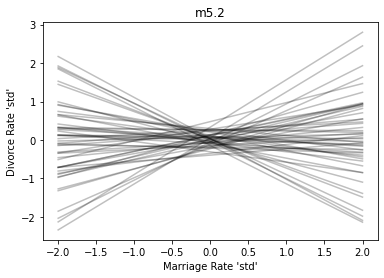

In [8]:
_, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, b in zip(prior_checks["a"], prior_checks["bM"]):
    y = a + b * x
    ax.plot(x, y, c="k", alpha=0.25)

ax.set_xlabel("Marriage Rate 'std'")
ax.set_ylabel("Divorce Rate 'std'")
ax.set_title("m5.2")

In [9]:
with pm.Model() as m5_3:
    a = pm.Normal("a", 0.0, 0.2)
    bM = pm.Normal("bM", 0.0, 0.5)
    bA = pm.Normal("bA", 0.0, 0.5)
    mu = a + bM * data_M + bA * data_A
    sigma = pm.Exponential("sigma", 1.0)
    obs = pm.Normal("Divorce", mu=mu, sigma=sigma, observed=data_D)
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=10)
    trace = pm.sample(1000, tune=2000, random_seed=10)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, bM, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:04<00:00, 1411.39draws/s]


In [10]:
func_dict = {
     "mean":  np.mean,
     "sd":    np.std,
     "5.5%":  lambda x: np.percentile(x, 5.5),
     "94.5%": lambda x: np.percentile(x, 94.5),
 }

In [11]:
pm.summary(trace, var_names=["a", "bM", "bA", "sigma"],stat_funcs=func_dict,round_to=2,extend=False)

,mean,sd,5.5%,94.5%
a,0.00,0.10,-0.15,0.17
bM,-0.07,0.16,-0.33,0.19
bA,-0.60,0.16,-0.85,-0.35
sigma,0.82,0.09,0.70,0.97


In [12]:
data = pd.read_csv("milk.csv",sep=';').dropna()
data.rename(columns=lambda x: x.replace(".","_"),inplace=True)
data.head()

,clade,species,kcal_per_g,perc_fat,perc_protein,perc_lactose,mass,neocortex_perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
5,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54
6,New World Monkey,A palliata,0.56,29.66,23.46,46.88,5.37,64.54
7,New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,2.51,67.64
9,New World Monkey,S sciureus,0.92,50.58,22.33,27.09,0.68,68.85


In [13]:
data_K = (data.kcal_per_g - data.kcal_per_g.mean() ) / data.kcal_per_g.std()
data_N = (data.neocortex_perc - data.neocortex_perc.mean() ) / data.neocortex_perc.std()
data_M = (np.log(data.mass) - np.mean(np.log(data.mass)) ) / np.std(np.log(data.mass))

In [14]:
with pm.Model() as m5_5_draft:
    a = pm.Normal("a", 0.0, 1.0)
    bN = pm.Normal("bN", 0.0, 1.0)
    mu = a + bN * data_N
    sigma = pm.Exponential("sigma", 1.0)
    obs = pm.Normal("kcal_per_g", mu=mu, sigma=sigma, observed=data_K)
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=10)

Text(0.5, 1.0, 'm5.2')

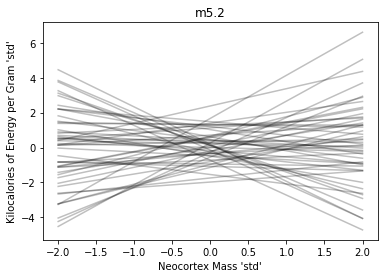

In [15]:
_, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, b in zip(prior_checks["a"], prior_checks["bN"]):
    y = a + b * x
    ax.plot(x, y, c="k", alpha=0.25)

ax.set_xlabel("Neocortex Mass 'std'")
ax.set_ylabel("Kilocalories of Energy per Gram 'std'")
ax.set_title("m5.2")